# K-Nearest Neighbors Classification

This is a user-friendly Jupyter Notebook version of KNN classifier. It allows users to:

- Upload a dataset
- Choose parameters for K-Nearest Neighbors (KNN)
- Select cross validation methods
- View classification results (accuracy, sensitivity, specificity)
- Visualize the confusion matrix for both training ans validation sets
- Visualizw score report for each sample    


## Import Libraries

In [10]:
# Import required libraries
import numpy as np # Numerical operations
import pandas as pd  # For data manipulation and analysis
from sklearn.model_selection import LeaveOneOut, GridSearchCV  # Cross-validation strategies
from sklearn.neighbors import KNeighborsClassifier  # KNN model
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, roc_auc_score  # Evaluation metrics
import ipywidgets as widgets
from ipywidgets import IntSlider, Dropdown, Button, HBox, VBox, Label, Layout   # For UI Control
from IPython.display import display, clear_output, HTML
import io  # Provides tools for handling input/output
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from collections import defaultdict


## Interactive UI
* Click the "Upload File" button and choose the input .csv file.

In [2]:
# File upload and run button
uploader = widgets.FileUpload(accept='.csv', multiple=False, description="Upload File")
run_button = widgets.Button(description='Run KNN', button_style='success')
output = widgets.Output()

display(HTML("<b>Upload CSV File</b>"))
display(uploader)

FileUpload(value=(), accept='.csv', description='Upload File')

#### Note: Don't run this cell again after uploading the file! This cell should only be run once when you start the notebook.

## Define functions
Below are helper functions for the notebook. You need run them all before checking the KNN results.

In [3]:
# Customized function for calculating weights
def compute_weights(weight, dist = None, for_sklearn = False):
    if for_sklearn:
        if weight == 'one':
            return 'uniform'
        elif weight == 'inverse':
            return 'distance'
        else:
            return lambda d: 1 / (d**2 + 1e-5)

    else:
        if weight == "one":
            return np.ones(len(dist))
        elif weight == "inverse":
            return 1 / (dist + 1e-5)
        else:
            return 1 / (dist**2 + 1e-5)

# Calculate scores for each sample
def accumulate_scores(score_matrix, idx, neighbor_labels, weights_arr, class_indices):
    class_weight_sum = defaultdict(float)     
    # For each test sample, get the weighted score for each class
    for lbl, w in zip(neighbor_labels, weights_arr):
        class_weight_sum[lbl] += w
    for cls_idx in class_indices:
        score_matrix[idx, cls_idx] += class_weight_sum.get(cls_idx, 0.0)


# Calculate specificity
def compute_specificity(cm):
    specificity = []
    for i in range(len(cm)):  # For each class
        TP = cm[i][i]  # True positives for class i
        FP = sum(cm[:, i]) - TP  # False positives for class i
        FN = sum(cm[i, :]) - TP  # False negatives for class i
        TN = cm.sum() - (TP + FP + FN)  # True negatives for class i
        denom = TN + FP
        specificity.append(TN / denom if denom else 0.0)  # Avoid division by zero
    return np.array(specificity)

In [4]:

def evaluate_final(X, y, k, metric, weights):
    global train_true, train_pred, train_cm, sample_scores
    
    # Final Model Evaluation on Full Dataset
    class_indices = list(range(len(class_names)))
    model = KNeighborsClassifier(n_neighbors=k, metric=metric, weights=compute_weights(weights, for_sklearn=True))
    model.fit(X, y_encoded)
    y_pred = model.predict(X)

    # Store results
    train_true = y_encoded
    train_pred = y_pred
    train_cm = confusion_matrix(train_true, train_pred, labels=class_indices)
    train_acc = accuracy_score(train_true, train_pred)

    # Calculate scores 
    n_classes = len(set(y_encoded))
    sample_scores = np.zeros((len(X), n_classes))

    # Get neighbors of each sample (including self)
    neigh_dists, neigh_indices = model.kneighbors(X, n_neighbors=k)

    # Compute scores for each sample
    for i in range(len(X)):
        neighbors = neigh_indices[i]
        dists = neigh_dists[i]
        weights_arr = compute_weights(weights, dists)
        neighbor_labels = y_encoded[neighbors]
        accumulate_scores(sample_scores, i, neighbor_labels, weights_arr, class_indices)

    
    
    display(HTML('<div style="text-align:left;"><strong>Summary Report</strong></div>'))

    print(f"\n\nRunning Final KNN with k={k}")
    print("Model trained and evaluated on the full dataset")
    print(f"Input file name: {file_name}\n")
    
    print(f"Overall Accuracy\t{train_acc * 100:.2f}% ({int(train_acc * len(train_true))}/{len(train_true)})")
   

    train_recall = recall_score(train_true, train_pred, labels=class_indices, average=None, zero_division=0)
    train_specificity = compute_specificity(train_cm)

    for i, cls in enumerate(class_names):
        train_sens = train_recall[i] * 100  
        train_spec = train_specificity[i] * 100
        train_ner = (train_recall[i] + train_specificity[i]) / 2 * 100
        
        tp_train = train_cm[i][i]
        fn_train = train_cm[i, :].sum() - tp_train
        fp_train = train_cm[:, i].sum() - tp_train
        tn_train = train_cm.sum() - (tp_train + fn_train + fp_train)

        print("")
        
        print(f"{cls:<10}{'Sensitivity':>20}{'Selectivity':>25}{'Non-Error Rate':>25}")
        print(f"{' ':<10}{train_sens:>14.2f}% ({tp_train}/{tp_train+fn_train}){train_spec:>17.2f}% ({tn_train}/{tn_train+fp_train}){train_ner:>21.2f}%")
       
    print("\n\n")
    return train_cm, class_names, train_true, train_pred, sample_scores, y_encoded

In [13]:
def run_grid_accuracy(X, y, metric, weights):
    global class_names, y_encoded, class_indices
    class_names = list(dict.fromkeys(y))
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    y_encoded = np.array([label_to_index[label] for label in y])
    class_indices = list(range(len(class_names)))
    
    # === Grid Search for best K ===
    param_grid = {'n_neighbors': list(range(1, 21))}
    grid = GridSearchCV(
        KNeighborsClassifier(metric=metric, weights=compute_weights(weights, for_sklearn=True)),
        param_grid,
        cv=LeaveOneOut()
    )
    grid.fit(X, y_encoded)
    best_k = grid.best_params_['n_neighbors']
    best_score = grid.best_score_
    print(f"\nBest K: {best_k} (Mean LOOCV Accuracy: {best_score * 100:.2f}%)\n")
    evaluate_final(X, y, best_k, metric, weights)

def run_grid_roc(X, y, metric, weights):
    global class_names, y_encoded, class_indices, best_k_auc
    class_names = list(dict.fromkeys(y))
    label_to_index = {label: idx for idx, label in enumerate(class_names)}
    y_encoded = np.array([label_to_index[label] for label in y])
    class_indices = list(range(len(class_names)))
    n_classes = len(class_indices)

    k_values = list(range(1, 21))
    auc_scores = []

    for k in k_values:
        probs = []
        truths = []

        loo = LeaveOneOut()
        for train_index, test_index in loo.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y_encoded[train_index], y_encoded[test_index]

            model = KNeighborsClassifier(
                n_neighbors=k,
                metric=metric,
                weights=compute_weights(weights, for_sklearn=True)
            )
            model.fit(X_train, y_train)

            # Predict class probabilities for the test sample
            proba = model.predict_proba(X_test)[0]
            probs.append(proba)            # Shape: (n_classes,)
            truths.append(y_test[0])       # Single int label

        try:
            auc = roc_auc_score(
                truths,
                probs,
                multi_class='ovr',          # One-vs-rest strategy
                average='macro'             # Macro-averaged AUC
            )
        except ValueError:
            auc = float('nan')  # If only one class is in truths, skip

        auc_scores.append(auc)

    # Get best k
    auc_scores = np.array(auc_scores)
    best_idx = np.nanargmax(auc_scores)
    best_k = k_values[best_idx]
    best_auc = auc_scores[best_idx]

    print(f"\nBest K (Macro AUC): {best_k} (Mean LOOCV AUC: {best_auc:.4f})\n")

    # Evaluate final model on full dataset
    evaluate_final(X, y, best_k, metric, weights)
   
    

#### Make sure you have uploaded the input file, then run the code below. Click the green button to run KNN method.

In [12]:
def get_file_content():
    with output:  # All printed output will appear inside the 'output' widget
        output.clear_output()  # Clear previous output
        if not uploader.value:
            print("⚠️ No file uploaded. Please choose the input file and re-run the code above.")
            return False
        else:
            global file_name, X, y
            value = uploader.value
            
            # Handle multiple possible structures: dict, tuple, list
            if isinstance(value, dict):
                uploaded_file = list(value.values())[0]
            elif isinstance(value, (list, tuple)):
                uploaded_file = value[0]
            else:
                print("Unsupported uploader value format.")
                return False
            content = uploaded_file['content']                # Binary content of the file
            file_name = uploaded_file['name']        
            try:
                data = pd.read_csv(io.BytesIO(content))     # Read into a DataFrame from memory buffer
                X = data.drop(columns=['NAME', 'CLASS'])    # Use all columns except 'NAME' and 'CLASS' as features
                y = data['CLASS']                           # Use 'CLASS' as the target label
                return True
            except Exception as e:
                # Catch and display any error that occurs during file read or processing
                print(f"Error: {e}")
                return False
            
def on_accuracy_clicked(b):  
    if get_file_content():
        with output:
            run_grid_accuracy(X, y, metric="euclidean", weights="one")

def on_roc_clicked(b):
    if get_file_content():
        with output:
            run_grid_roc(X, y, metric="euclidean", weights="one")  # Or use your widget values here

output = widgets.Output()
output.clear_output()

# Run button
accuracy_button = widgets.Button(description='Grid Search (default)', button_style='success')
roc_button = widgets.Button(description='Grid Search (ROC)', button_style='info')

accuracy_button.on_click(on_accuracy_clicked)
roc_button.on_click(on_roc_clicked)


# === Final Output Display ===
display(
    widgets.HBox([accuracy_button, roc_button]),
    output
)

Output()

####  Run the cell below to plot confusion matrix heatmaps for training and validation datasets.

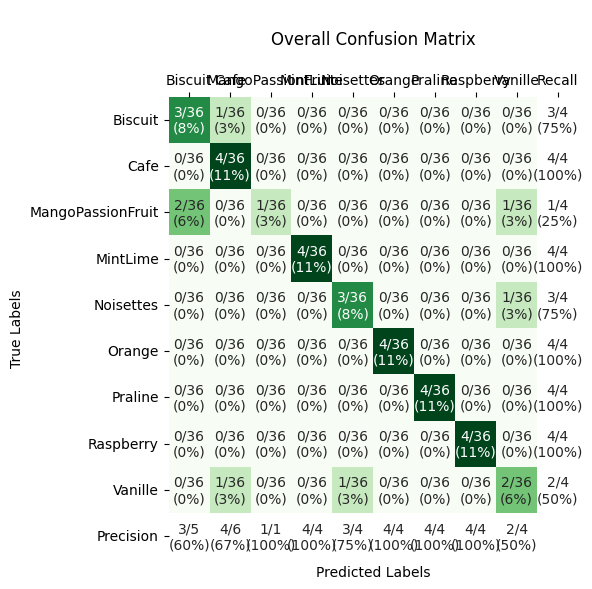

In [7]:
def plot_confusion_matrix_heatmap_with_metrics(cm, labels, true_labels, pred_labels, title):
    total = cm.sum()
    n = len(labels)

    # Create annotated matrix (n+1)x(n+1)
    annotated_cm = np.empty((n + 1, n + 1), dtype=object)

    # Fill confusion matrix cells
    for i in range(n):
        for j in range(n):
            count = cm[i, j]
            percent = round(count / total * 100)
            annotated_cm[i, j] = f"{count}/{total}\n({percent}%)"

    # Add recall (rightmost column)
    recalls = recall_score(true_labels, pred_labels, labels=range(n), average=None, zero_division=0)
    for i in range(n):
        correct = cm[i, i]
        total_true = cm[i].sum()
        recall_pct = round(recalls[i] * 100)
        annotated_cm[i, -1] = f"{correct}/{total_true if total_true else 1}\n({recall_pct}%)"

    # Add precision (bottom row)
    precisions = precision_score(true_labels, pred_labels, labels=range(n), average=None, zero_division=0)
    for j in range(n):
        correct = cm[j, j]
        total_pred = cm[:, j].sum()
        precision_pct = round(precisions[j] * 100)
        annotated_cm[-1, j] = f"{correct}/{total_pred if total_pred else 1}\n({precision_pct}%)"

    annotated_cm[-1, -1] = ""  # bottom-right corner

    # Extend the original confusion matrix with zeros to match shape
    extended_cm = np.zeros((n + 1, n + 1))
    extended_cm[:n, :n] = cm

    # Create extended label set
    xticklabels = list(labels) + ["Recall"]
    yticklabels = list(labels) + ["Precision"]

    # Plot
    plt.figure(figsize=(6, 6))
    ax = sns.heatmap(extended_cm, annot=annotated_cm, fmt="", cmap="Greens",
                xticklabels=xticklabels, yticklabels=yticklabels, cbar=False,
                linewidths=0, linecolor='gray')
    ax.xaxis.set_ticks_position('top')       # Move ticks to top

    # Determine number of rows and columns
    nrows, ncols = extended_cm.shape
    
    # Highlight last row and last column
    for i in range(nrows):
        for j in range(ncols):
            if i == nrows - 1 or j == ncols - 1:
                # Calculate patch position: seaborn heatmap uses (col, row) as (x, y)
                rect = plt.Rectangle(
                    (j, i), 1, 1,
                    fill=True,
                    facecolor='white',   # Light yellow
                    edgecolor='black',
                    linewidth=0
                )
                ax.add_patch(rect)
    
    # Redraw annotations on top
    for t in ax.texts:
        t.set_zorder(10)
    
    plt.title(title)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.tight_layout()
    plt.show()

plot_confusion_matrix_heatmap_with_metrics(train_cm, class_names, train_true, train_pred, "\nOverall Confusion Matrix\n")  # Training confusion matrix

#### Run the code below to plot scores for each item in the training and validation datasets

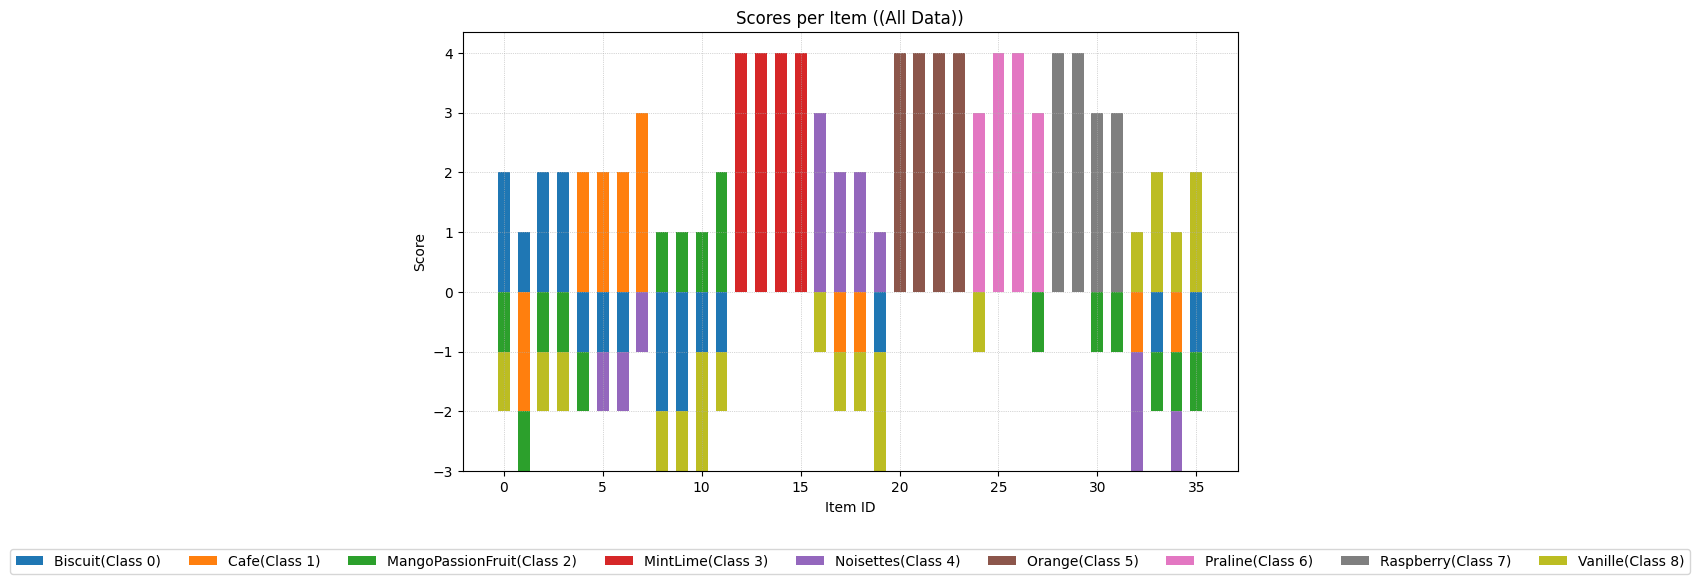

In [8]:
# Plot score plots for training and testing samples
def plot_scores (scores, class_names, true_labels,score_set):
    n_items = scores.shape[0]
    n_classes = len(class_names)  # Can be 2, 3, or more

    # Generate distinct colors using a colormap
    cmap = plt.colormaps['tab10']  # Or try 'tab20', 'Set3', etc.
    class_colors = {i: cmap(i % cmap.N) for i in range(n_classes)}
    
    # Initialize bar positions for stacking
    pos_bottoms = np.zeros(n_items)
    neg_bottoms = np.zeros(n_items)

    plt.figure(figsize=(14, 6))

    for cls in range(n_classes):
        values = []
        bottoms = []
        colors = []

        for i in range(n_items):
            score = scores[i, cls]
            is_true_class = (cls == true_labels[i])

            if is_true_class:
                values.append(score)
                bottoms.append(pos_bottoms[i])
                pos_bottoms[i] += score  # Accumulate for next class
            else:
                values.append(-score)
                bottoms.append(neg_bottoms[i])
                neg_bottoms[i] -= score  # Accumulate downward
            colors.append(class_colors[cls])

        # Draw bars for this class across all items
        plt.bar(range(n_items), values, bottom=bottoms, color=colors, width=0.6)

    #print(scores)
    plt.xlabel('Item ID')
    plt.ylabel('Score')
    plt.title(f'Scores per Item ({score_set})')
    
    # Custom legend
    legend_elements = [Patch(facecolor=class_colors[i], label=f'{class_names[i]}(Class {i})') for i in range(n_classes)]
    plt.legend(handles=legend_elements, loc='lower center', bbox_to_anchor=(0.5, -0.25), ncol=n_classes)
    plt.grid(True, linestyle=':', linewidth=0.5)
    plt.tight_layout()
    plt.show()

display(HTML('<div style="text-align:center;"><strong>Score Report</strong></div>'))
plot_scores(sample_scores, class_names, y_encoded, "(All Data)")
